In [1]:
import dio, util
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict

### Read in  data

In [192]:
tasks = util.read_tasks_config('tasks.cfg')
# tasks = {'com': tasks['com'], 'fn': tasks['fn']}
# dio.load_clusters('w2c.10240.txt', 'in')
data = dio.read_data('data.cfg', input_type=dio.INDICES, tasks=tasks)

Reading data... 
Fitting input vectorizer with 'ccg' training data...

Fitting input vectorizer with 'chunking' training data...

Fitting input vectorizer with 'com' training data...

Fitting input vectorizer with 'fnt' training data...

Fitting input vectorizer with 'gpos' training data...

Fitting input vectorizer with 'hyperlinks' training data...

Fitting input vectorizer with 'keysem17' training data...

Fitting input vectorizer with 'mwe' training data...

Fitting input vectorizer with 'semcor' training data...

Fitting input vectorizer with 'streusle' training data...
Done!


### Vectorize all input data and labels

Do this for all tasls. Building one matrix for some tasks means we have to pad the input data. Using default length 50 here.

In [195]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

# train data
xs, ys, bows = {}, {}, {}
for task, task_cfg in tasks.items():
    x = data.input_vectorizer.transform(data.corpora[task]['train']['in'], pad_len=30)
    y = data.output_vectorizers[task].transform(data.corpora[task]['train']['out'], pad_len=30)
    xs[task] = x
    ys[task] = y
    bows[task] = cv.fit_transform([' '.join(sent) for sent in data.corpora[task]['train']['in']])
    
# dev data
xs_dev, ys_dev = {}, {}
for task, task_cfg in tasks.items():
    x = data.input_vectorizer.transform(data.corpora[task]['dev']['in'], pad_len=30)
    x = data.output_vectorizers[task].transform(data.corpora[task]['dev']['out'], pad_len=30)
    xs_dev[task] = x
    ys_dev[task] = y

(39604, 31347)
(15465, 28508)
(3312, 5360)
(3711, 8233)
(3312, 5360)
(2398, 6260)
(2000, 9189)
(9600, 24253)
(1002, 4467)
(8936, 14840)


### Compute word distributions

In [4]:
from collections import Counter
from scipy.stats import entropy

# http://stackoverflow.com/questions/15880133/jensen-shannon-divergence
def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))
    
    
voc_len = 10242
jsds = {}

for task in tasks:
    c = Counter(xs[task].flat)
    dist_tr = np.array([c[i] for i in range(voc_len)])
    c_dev = Counter(xs_dev[task].flat)
    dist_dev = np.array([c_dev[i] for i in range(voc_len)])    
    jsds[task] = JSD(dist_tr, dist_dev)




### Single-task model parameters

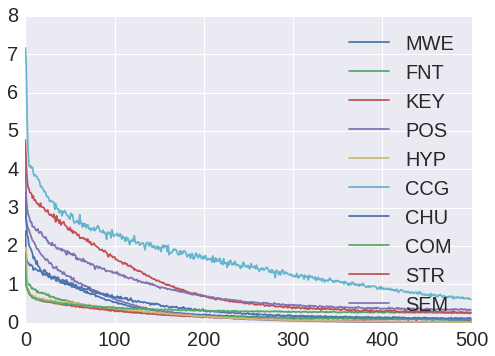

In [318]:
from scipy.optimize import curve_fit

def read_learning_curve(f):
    iter_loss = []
    for line in open(f):
        spl = line.split()
        iter_loss.append((int(spl[1].strip(',')), float(spl[5].strip(','))))
    return iter_loss

def func(x, a, b, c, d):
    return a + b * np.log(np.multiply(x,c)+d)

def get_curve_params(task):
    xs, ys = zip(*read_learning_curve('logs/{}/loss_tr.log'.format(task)))
    popt, _ = curve_fit(func, xs[:5000:10], ys[:5000:10])
    return popt[1], popt[2]

def get_curve_gradients(task, pos=[0.001, 0.4, 0.6, 0.8]):
    def get_gradient_at(xs, ys, i):
        xbefore = xs[i-1]
        ybefore = ys[i-1]
        xafter = xs[i+1]
        yafter = ys[i+1]
        return (yafter-ybefore)/(xafter-xbefore)
    
    xs, ys = zip(*read_learning_curve('logs/{}/loss_tr.log'.format(task)))
    gradients = []
    for p in pos:
        gradients.append(get_gradient_at(xs, ys, int(len(xs)*p)))
    return gradients

import matplotlib.pyplot as plt
iters, mwe_loss = zip(*read_learning_curve("logs/mwe/loss_tr.log"))
iters, fnt_loss = zip(*read_learning_curve("logs/fnt/loss_tr.log"))
iters, key_loss = zip(*read_learning_curve("logs/keysem17/loss_tr.log"))
iters, gpos_loss = zip(*read_learning_curve("logs/gpos/loss_tr.log"))
iters, hyp_loss = zip(*read_learning_curve("logs/hyperlinks/loss_tr.log"))
iters, ccg_loss = zip(*read_learning_curve("logs/ccg/loss_tr.log"))
iters, com_loss = zip(*read_learning_curve("logs/com/loss_tr.log"))
iters, str_loss = zip(*read_learning_curve("logs/streusle/loss_tr.log"))
iters, sem_loss = zip(*read_learning_curve("logs/semcor/loss_tr.log"))
iters, chu_loss = zip(*read_learning_curve("logs/chunking/loss_tr.log"))

plt.plot(mwe_loss[:5000:10], label='MWE')
plt.plot(fnt_loss[:5000:10], label='FNT')
plt.plot(key_loss[:5000:10], label='KEY')
plt.plot(gpos_loss[:5000:10], label="POS")
plt.plot(hyp_loss[:5000:10], label="HYP")
plt.plot(ccg_loss[:5000:10], label="CCG")
plt.plot(chu_loss[:5000:10], label="CHU")
plt.plot(com_loss[:5000:10], label="COM")
plt.plot(str_loss[:5000:10], label="STR")
plt.plot(sem_loss[:5000:10], label="SEM")

plt.legend()
plt.savefig('loss.png')


    

### Collect features for every task/dataset

In [1]:
voc = set([l.strip() for l in open("emb_voc.txt")])
print(len(voc))

400004


In [296]:
featuredicts = {}
import scipy

def get_types_tokens(x):
    tokens = [w for w in x.flat if w > 1]  # indices 0 and 1 are reserved for PAD and GO
    return set(tokens), tokens

for task in sorted(tasks):
    labels = [y for y in ys[task].flat if y>3]
    D = {}
    print("=== {} ===".format(task))
    # nuclear norm: sum of singular values
    D["fro_norm"] = scipy.sparse.linalg.norm(bows[task], ord='fro')
    # length of dataset
    D["length"] = xs[task].shape[0]
    # number of labels
    D["n_labels"] = tasks[task].get_num_labels()-4
    # labels entropy
    D["label_entropy"] = entropy([count for lbl, count in Counter(labels).items()])
    # token/type ratio
    types, tokens = get_types_tokens(xs[task])
    D["tokens/types"] = len(tokens)/len(types)
    # BOW JS divergence train/test
    D["js_div"] = jsds[task]
    # OOV rate
    all_words = [w for sent in data.corpora[task]['train']['in'] for w in sent]
    D["oov_rate"] = len([w for w in all_words if w not in voc]) / len(all_words) * 100
    # Learning curve gradients
    grads = get_curve_gradients(task, [0.1, 0.2, 0.3, 0.5, 0.7])
    D["loss_grad_10"] = grads[0]
    D["loss_grad_20"] = grads[1]
    D["loss_grad_30"] = grads[2]
    D["loss_grad_50"] = grads[3]
    D["loss_grad_70"] = grads[4]
    params = get_curve_params(task)
    D["curve_steepness0"] = params[0]
    D["curve_steepness1"] = params[1]
    # add to featuredicts
    print(D["loss_grad_30"])
    print()
    featuredicts[task] = D 

=== ccg ===
-0.006298333406448364

=== chunking ===
0.001435372233390808

=== com ===
5.260854959487915e-05

=== fnt ===
4.1321665048599246e-05

=== gpos ===
-0.0006624087691307068

=== hyperlinks ===
-0.0008521348237991333

=== keysem17 ===
-9.096264839172363e-05

=== mwe ===
-7.283687591552734e-05

=== semcor ===
0.0011842578649520874

=== streusle ===
0.00032129883766174316



### Pair tasks
Compute features for pairs of tasks, where one task is treated as main and the other as auxiliary. A single instance in this set is a concatenation of the features collected above for the main task, the aux task, and the ratio of the two.

In [283]:
v = DictVectorizer()
paired_feats = {}

for main_task, main_task_feats in featuredicts.items():
    for aux_task, aux_task_feats in featuredicts.items():
        if main_task == aux_task: continue
        D = {}
        for feat in main_task_feats.keys():
            D["main_"+feat] = main_task_feats[feat]
            D["aux_"+feat] = aux_task_feats[feat]
            D["main/aux_"+feat] = main_task_feats[feat] / aux_task_feats[feat]
        paired_feats[main_task+"_"+aux_task] = D

print(len(paired_feats))


90


### Compute performance differences between STL/MTL


In [161]:
def get_f1(file, task, iters):
    """
    gets accuracy of specfic task in loss_dv logfile at iters iterations
    """
    f = open(file)
    for line in f:
        line = line.strip().replace(',', '').split()
        if int(line[1]) == iters:
            if line[3] == task:
                acc = float(line[9])
                break
    f.close()
    return acc

# collect all accuracies after 50k batches for single tasks and 100k batches for MTL exps
accs = {}
diffs = {}
for task1 in tasks.keys():
    accs[task1] = get_f1('logs/{}/loss_dv.log'.format(task1), task1 , 50000)
    for task2 in tasks.keys():
        if task1 == task2: continue
        exppair = '_'.join(sorted([task1, task2]))
        accs[task1+'_'+task2] = get_performance('logs/{}/loss_dv.log'.format(exppair), task1 , 100000)
        # accuracy ratio between STL and MTL
        diffs[task1+'_'+task2] = (accs[task1+'_'+task2] / accs[task1]  -1) * 100
        
# print(diffs)
gains = sorted([(pair, diff) for pair, diff in diffs.items() if diff > 0], key=lambda x: x[1], reverse=True)
losses = sorted([(pair, diff) for pair, diff in diffs.items() if diff <= 0], key=lambda x: x[1], reverse=True)

print("GAINS ({})".format(len(gains)))
print(gains)
print("\n\nLOSSES ({})".format(len(losses)))
print(losses)

print("\n\nMost helpful tasks")
aux_task_helpfulness = Counter([task.split('_')[1] for task, diff in gains])
print(aux_task_helpfulness)

GAINS (40)
[('hyperlinks_semcor', 23.200162754621978), ('hyperlinks_gpos', 22.243979350507324), ('mwe_chunking', 19.564614531336645), ('mwe_ccg', 17.979293769643178), ('mwe_semcor', 15.977999630245886), ('hyperlinks_ccg', 12.0514711492002), ('hyperlinks_fnt', 9.175291813951114), ('mwe_streusle', 8.610648918469233), ('hyperlinks_streusle', 8.086870279480207), ('mwe_com', 7.378905527824009), ('keysem17_ccg', 5.653595277566903), ('mwe_fnt', 5.502403401737843), ('gpos_ccg', 4.8887059877267935), ('hyperlinks_chunking', 4.018004730056202), ('gpos_semcor', 3.363633062612714), ('keysem17_chunking', 3.21491098957285), ('gpos_chunking', 2.8746414263063125), ('gpos_streusle', 2.8673791742819477), ('gpos_com', 1.8712402716082321), ('ccg_gpos', 1.8078938501399966), ('streusle_semcor', 1.7171010910746576), ('mwe_gpos', 1.63847291551118), ('streusle_chunking', 1.4585603017935211), ('hyperlinks_keysem17', 1.454619433919091), ('ccg_chunking', 1.3803199832688406), ('ccg_semcor', 1.3652154716674136), ('c

### Analyzing task contribution

['ccg', 'chunking', 'com', 'fnt', 'gpos', 'hyperlinks', 'keysem17', 'mwe', 'semcor', 'streusle']


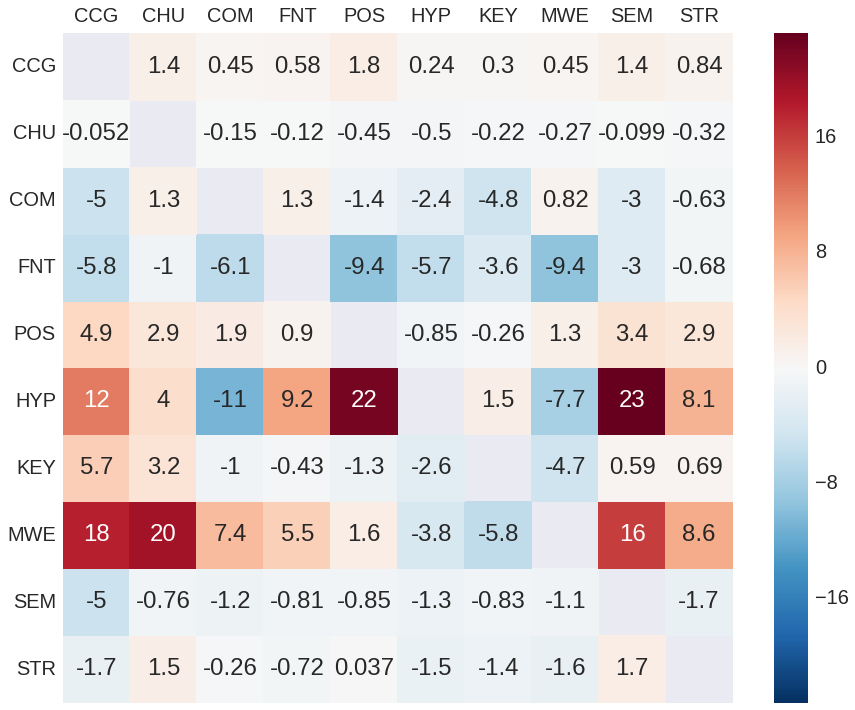

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matrix = np.zeros([len(tasks), len(tasks)])
for i, task1 in enumerate(sorted(tasks)):
    for j, task2 in enumerate(sorted(tasks)):
        if not task1 == task2:
            matrix[i,j] = diffs[task1+'_'+task2]
        
fig, ax = plt.subplots(figsize=(15,12))  
sns.set(font_scale=2)

# mask diagonal
mask = np.zeros_like(matrix)
for diag in range(len(mask)):
    mask[diag,diag] = True

heatmap = sns.heatmap(matrix, mask=mask, annot=True, ax=ax, cmap="RdBu_r")
ax.xaxis.set_ticks_position('top')
print(sorted(tasks))
labels="CCG Chunking Compression FNT POS Hyperlinks Keyphrases MWE Semcor Streusle".split()
xlabels="CCG CHU COM FNT POS HYP KEY MWE Sem Str".upper().split()
ax.set_xticklabels(xlabels, minor=False, rotation=0)
ax.set_yticklabels(xlabels[::-1], minor=False, rotation=0)
plt.show()
fig.savefig('heatmap.png')

# Prediction
Try to predict helpfulness of MTL based on differences in performance, using logistic regression

### Preprocessing

In [287]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler

v = DictVectorizer(sparse=False)

X, y = [], []
xs_dicts=[]
pair_seq = [p for p in paired_feats.keys()]
for pair in pair_seq:
    xs_dicts.append(paired_feats[pair])
    y.append(diffs[pair])
X = v.fit_transform(xs_dicts)

X = MinMaxScaler().fit_transform(X)

## Classification
### All features

In [294]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
y_log = np.sign(y)
lr = LogisticRegression()
lr.fit(X, y_log)
print(lr.score(X, y_log))
# print(lr.score(X_train, y_train))

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import RFE

feature_ranks = defaultdict(list)
feature_coeffs = defaultdict(list)
for _ in range(100):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y_log, test_size=0.2, random_state=np.random.randint(100))
    rfe = RFE(lr, len(lr.coef_))
    rfe.fit(X_tr, y_tr)
    lr = LogisticRegression()
    lr.fit(X_tr, y_tr)
    for feat_id, rank in enumerate(rfe.ranking_):
        feature_ranks[feat_id].append(rank)
        feature_coeffs[feat_id].append(lr.coef_[0][feat_id])

ranking = sorted([(feat_id, v.feature_names_[feat_id], np.array(ranks).mean()) 
                  for feat_id, ranks in feature_ranks.items()], key=lambda x: x[2])
print(ranking)

coefranking = sorted([(feat_id, v.feature_names_[feat_id], np.array(coef).mean()) 
                  for feat_id, coef in feature_coeffs.items()], key=lambda x: abs(x[2]), reverse=True)

print()
for fid, fname, coef in coefranking:
    print(fname, coef)

# print(rfe.score(X, y_log))

# TODO fit RFE in several iterations with random train/test splits, record avg rank of each feature

0.888888888889
[(36, 'main_loss_grad_30', 1.0), (4, 'aux_label_entropy', 3.3999999999999999), (29, 'main_curve_steepness1', 3.71), (35, 'main_loss_grad_20', 4.7999999999999998), (40, 'main_oov_rate', 6.1900000000000004), (8, 'aux_loss_grad_30', 6.29), (37, 'main_loss_grad_50', 7.4000000000000004), (26, 'main/aux_oov_rate', 7.5300000000000002), (39, 'main_n_labels', 8.0899999999999999), (30, 'main_fro_norm', 10.970000000000001), (18, 'main/aux_label_entropy', 12.539999999999999), (7, 'aux_loss_grad_20', 14.32), (25, 'main/aux_n_labels', 14.460000000000001), (38, 'main_loss_grad_70', 14.529999999999999), (2, 'aux_fro_norm', 15.69), (0, 'aux_curve_steepness0', 18.870000000000001), (41, 'main_tokens/types', 19.030000000000001), (10, 'aux_loss_grad_70', 20.02), (13, 'aux_tokens/types', 20.699999999999999), (6, 'aux_loss_grad_10', 20.829999999999998), (16, 'main/aux_fro_norm', 22.300000000000001), (14, 'main/aux_curve_steepness0', 22.620000000000001), (5, 'aux_length', 23.760000000000002), (

In [295]:
import warnings
warnings.filterwarnings("ignore")

X_abl = X
means = []
print("All features")
for _ in range(100):
    lr = LogisticRegression()
    shuffle = KFold(n_splits=5, shuffle=True, random_state=np.random.randint(100))
    scores = cross_val_score(lr, X_abl, y_log, cv=shuffle, scoring='f1')
    means.append(scores.mean())
means= np.array(means)
print(means.mean(), means.std())
print()

for feat_id, feat_name, avg_rank in ranking[::-1]:
    for x in X_abl:
        x[feat_id] = 0
    print(feat_id, feat_name)
    means = []
    for _ in range(100):
        lr = LogisticRegression()
        shuffle = KFold(n_splits=5, shuffle=True, random_state=np.random.randint(100))
        scores = cross_val_score(lr, X_abl, y_log, cv=shuffle, scoring='f1')
        means.append(scores.mean())
    means= np.array(means)
    print(means.mean(), means.std())
    print()

# feats = sorted([(f, lr.coef_[0][i]) for i, f in enumerate(v.feature_names_)], key=lambda x: abs(x[1]), reverse=True)
# for f in feats:    
#     print(f)
    

All features
0.668625222645 0.0412209332315

19 main/aux_length
0.672778584367 0.0409667625765

22 main/aux_loss_grad_30
0.673839034976 0.0435939859929

24 main/aux_loss_grad_70
0.671125265687 0.0437586251408

33 main_length
0.671656514435 0.0392643689153

20 main/aux_loss_grad_10
0.676262389245 0.0404401065145

17 main/aux_js_div
0.670101483656 0.044942303407

28 main_curve_steepness0
0.671069056692 0.0431601634108

23 main/aux_loss_grad_50
0.674050235334 0.0415769385401

21 main/aux_loss_grad_20
0.675816822445 0.0396203149333

34 main_loss_grad_10
0.670076958284 0.0374741688659

9 aux_loss_grad_50
0.679906826387 0.0429277208858

27 main/aux_tokens/types
0.679281153539 0.0446389381068

31 main_js_div
0.678034234221 0.0361681404076

32 main_label_entropy
0.688768329658 0.0416889292191

12 aux_oov_rate
0.694478887298 0.0407112559679

3 aux_js_div
0.693856871989 0.0382382626645

11 aux_n_labels
0.699347698603 0.0371473571082

1 aux_curve_steepness1
0.699063154407 0.0443672399551

15 main

### Data features only

In [280]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler

v = DictVectorizer(sparse=False)

X, y = [], []
xs_dicts=[]
pair_seq = [p for p in paired_feats.keys()]
for pair in pair_seq:
    x_dict = paired_feats[pair]
    delete_keys= [k for k in x_dict.keys() if "grad" in k or "curve" in k]
    for feat in delete_keys:
            x_dict.pop(feat)
    xs_dicts.append(x_dict)
    y.append(diffs[pair])
X = v.fit_transform(xs_dicts)

X = MinMaxScaler().fit_transform(X)

In [281]:
X_abl = X
means = []

print(X_abl[0], X_abl.shape)

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import RFE

feature_ranks = defaultdict(list)
for _ in range(100):
    lr = LogisticRegression()
    X_tr, X_te, y_tr, y_te = train_test_split(X, y_log, test_size=0.2)
    rfe = RFE(lr, 42)
    rfe.fit(X_tr, y_tr)
    for feat_id, rank in enumerate(rfe.ranking_):
        feature_ranks[feat_id].append(rank)

ranking = sorted([(feat_id, v.feature_names_[feat_id], np.array(ranks).mean()) 
                  for feat_id, ranks in feature_ranks.items()], key=lambda x: x[2])
print(ranking)
# print(rfe.score(X, y_log))
            
print("All features")
for _ in range(100):
    lr = LogisticRegression()
    shuffle = KFold(n_splits=5, shuffle=True, random_state=np.random.randint(100))
    scores = cross_val_score(lr, X_abl, y_log, cv=shuffle, scoring='f1')
    means.append(scores.mean())
means= np.array(means)
print(means.mean(), means.std())
print()

for feat_id, feat_name, avg_rank in ranking[::-1]:
    for x in X_abl:
        x[feat_id] = 0
    print(feat_id, feat_name)
    means = []
    for _ in range(100):
        lr = LogisticRegression()
        shuffle = KFold(n_splits=5, shuffle=True, random_state=np.random.randint(100))
        scores = cross_val_score(lr, X_abl, y_log, cv=shuffle, scoring='f1')
        means.append(scores.mean())
    means= np.array(means)
    print(means.mean(), means.std())
    print()

# feats = sorted([(f, lr.coef_[0][i]) for i, f in enumerate(v.feature_names_)], key=lambda x: abs(x[1]), reverse=True)
# for f in feats:    
#     print(f)
    

[ 0.19918826  0.71029611  0.04986286  0.03616393  0.          0.27880768
  0.29505596  0.2424462   0.23377364  0.5035391   0.16262989  0.05680705
  0.05144628  0.15587143  0.5757352   0.57170327  0.61142554  0.37466971
  0.05533905  0.29841724  0.39880945] (90, 21)
[(0, 'aux_fro_norm', 1.0), (1, 'aux_js_div', 1.0), (2, 'aux_label_entropy', 1.0), (3, 'aux_length', 1.0), (4, 'aux_n_labels', 1.0), (5, 'aux_oov_rate', 1.0), (6, 'aux_tokens/types', 1.0), (7, 'main/aux_fro_norm', 1.0), (8, 'main/aux_js_div', 1.0), (9, 'main/aux_label_entropy', 1.0), (10, 'main/aux_length', 1.0), (11, 'main/aux_n_labels', 1.0), (12, 'main/aux_oov_rate', 1.0), (13, 'main/aux_tokens/types', 1.0), (14, 'main_fro_norm', 1.0), (15, 'main_js_div', 1.0), (16, 'main_label_entropy', 1.0), (17, 'main_length', 1.0), (18, 'main_n_labels', 1.0), (19, 'main_oov_rate', 1.0), (20, 'main_tokens/types', 1.0)]
All features
0.527321843791 0.0446344238586

20 main_tokens/types
0.540041421478 0.0479753267555

19 main_oov_rate
0.54

### Linear Regression

In [145]:
lr = LinearRegression()
from sklearn.model_selection import cross_val_score, KFold
shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(lr, X, y, cv=shuffle)
print(scores.mean(), scores)

-0.82404923647 [-1.1160617   0.01449197 -1.9734492  -0.05134546 -0.99388179]


In [146]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=42)
lr = LinearRegression()

lr.fit(X, y)
print(lr.score(X, y))
# print(lr.score(X_train, y_train))
feats = sorted([(f, lr.coef_[i]) for i, f in enumerate(v.feature_names_)], key=lambda x: abs(x[1]), reverse=True)
for f in feats:    
    print(f)

0.593674959591
('aux_loss_grad_30', -116872976539522.78)
('aux_loss_grad_70', -105356520782891.58)
('aux_loss_grad_10', -74092294790496.25)
('aux_loss_grad_20', 69294732384059.008)
('aux_loss_grad_50', -67044131966574.938)
('aux_curve_steepness0', -64936623283893.867)
('aux_length', -56634101694847.766)
('aux_tokens/types', 53616824301639.812)
('aux_curve_steepness1', 44067220869800.133)
('aux_js_div', 36442805318538.781)
('aux_n_labels', -36385652100397.688)
('aux_nuc_norm', 16539696322286.0)
('main/aux_tokens/types', -49.04296875)
('main/aux_length', 27.43359375)
('main_curve_steepness1', 14.8203125)
('main_loss_grad_50', 13.8642578125)
('main/aux_curve_steepness1', -13.0078125)
('main/aux_curve_steepness0', 12.671875)
('main_js_div', 10.34375)
('main_length', -9.998046875)
('main/aux_loss_grad_20', 9.3271484375)
('main_tokens/types', -6.0556640625)
('main/aux_loss_grad_30', -5.748046875)
('main_loss_grad_70', 5.2314453125)
('main/aux_nuc_norm', 4.62109375)
('main/aux_js_div', 3.9023